In [94]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from carps.analysis.gather_data import filelogs_to_df, get_interpolated_performance_df, normalize_logs
from carps.analysis.generate_report import load_results
from carps.analysis.run_autorank import (
    calc_critical_difference,
    cd_evaluation,
    get_df_crit,
)
from carps.analysis.utils import (
    colorblind_palette,
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from dacboenv.experiment.analysis.utils import RWBM, create_yaml_string, postprocess_benchmarks, sort_df_by_mean
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from matplotlib.lines import Line2D
from omegaconf import OmegaConf

%matplotlib inline

df_final_processed_fn = "eval_final_perf.parquet"
logsprocessed_fn = "logs_processed.parquet"
logsprocessed_cfg_fn = "logs_processed_cfg.parquet"
key_performance = "log_regret"
result_dir = "../results_icml"
metabo_fn = "/scratch/hpc-prf-intexml/tklenke/repos/MetaBO/merged_rewards_total.csv"

def fix_benchmark_id(logs: pd.DataFrame) -> pd.DataFrame:
    def _fix_benchmark_id(row: pd.Series) -> str:
        if row["task_id"].startswith("bbob/2"):
            return "BBOB-2d"
        if row["task_id"].startswith("bbob/8"):
            return "BBOB-8d"
        return row["benchmark_id"]
    logs["benchmark_id"] = logs.apply(_fix_benchmark_id, axis="columns")
    return logs

def postprocess_logs(logs: pd.DataFrame, logs_cfg: pd.DataFrame) -> pd.DataFrame:
    print("Postprocess benchmarks...")
    logs = postprocess_benchmarks(logs, logs_cfg)
    print("Fix benchmark id...")
    logs = fix_benchmark_id(logs)
    print("Done postprocessing logs!")
    return logs

def load_logs(result_dir: str) -> tuple[pd.DataFrame,pd.DataFrame]:
    logs = load_results(Path(result_dir) / "logs.parquet", normalize=True)
    logs_cfg = pd.read_parquet(Path(result_dir) / "logs_cfg.parquet")
    logs = postprocess_logs(logs, logs_cfg)
    return logs, logs_cfg

def hatch_for_optimizer(opt):
    if opt.endswith("vbs"):
        return "xx"
    if opt.endswith("mean"):
        return "\\\\\\"
    if opt.endswith("--seed") or "--seed" in opt:
        return ""
    if opt in {"DefaultPolicy", "SAWEI-P", "Random"}:
        return ".."
    return ""

# Load and merge
skip_processing = True
if not (Path(result_dir) / logsprocessed_fn).is_file():
    skip_processing = False
    print(f"{Path(result_dir) / logsprocessed_fn} does not exist. Load and process.")

if not skip_processing:
    logs, logs_cfg = load_logs(result_dir=result_dir)
    logs.to_parquet(Path(result_dir) / logsprocessed_fn)
    logs_cfg.to_parquet(Path(result_dir) / logsprocessed_cfg_fn)
    df_final = filter_only_final_performance(logs)
    df_final.to_parquet(Path(result_dir) / df_final_processed_fn, index=False)


def fix_log_regret_inf(df: pd.DataFrame) -> pd.DataFrame:
    finite_vals = df.loc[
        np.isfinite(df["log_regret"]),
        "log_regret"
    ]
    floor = finite_vals.min() - 0.5
    df["solved"] = df["log_regret"].eq(-np.inf)
    df["log_regret"] = df["log_regret"].replace(-np.inf, floor)
    return df

def filter_experiments(df: pd.DataFrame) -> pd.DataFrame:
    optimizer_prefixes = [
        # "PPO-RNN-norm--dacbo_Cepisode_length_scaled_plus_logregret_AWEI-cont_Ssawei_Repisode_finished_scaled-DefaultAction_Ibbob2d_3seeds",
        "PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_fid8_3seeds",
        "PPO-MLP--dacbo_Csymlogregret_AWEI-skip_Ssawei_Rsymlogregret-SAWEI-P_Ibbob2d_3seeds",
        # "PPO",
        "DefaultPolicy",
        "Random",
        "SAWEI-P",
        "MetaBO-BBOB-8-2D-v0",
        "MetaBO-BBOB-2D-v0",
    ]
    df.loc[df["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
    df = df[df["optimizer_id"].map(lambda x: any(x.startswith(opt_id) for opt_id in optimizer_prefixes))].copy()
    # Rename MetaBO
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "MetaBO-Ros" if "MetaBO-BBOB-8-2D" in x else x)
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "MetaBO-BBOB" if "MetaBO-BBOB-2D" in x else x)
    # Rename PPO
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "PPO-Ros--" + x.split("--")[-1] if "fid8" in x else x)
    df["optimizer_id"] = df["optimizer_id"].map(lambda x: "PPO-BBOB--" + x.split("--")[-1] if "bbob2d_3s" in x else x)
    df.loc[df["optimizer_id"] == "SAWEI-P", "optimizer_id"] = "SAWEI"
    df.loc[df["optimizer_id"] == "DefaultPolicy", "optimizer_id"] = "Static"
    print(df["optimizer_id"].unique())
    return df

def load_df_final() -> pd.DataFrame:
    df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)
    df_metabo = pd.read_csv(metabo_fn)
    df_metabo = fix_benchmark_id(df_metabo)
    df_final = pd.concat([df_final, df_metabo])
    df_final = filter_experiments(df_final)
    df_final = fix_log_regret_inf(df_final)

    # Reduce PPO name
    df_final_ppo = df_final[df_final["optimizer_id"].str.startswith("PPO")].copy()
    df_final_ppo["outer_seed"] = df_final_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))

    # Average over outer seeds
    df_final_ppo_mean = df_final_ppo.groupby(["benchmark_id", "optimizer_id", "task_id", "seed"])["log_regret"].mean().reset_index().copy()
    df_final_ppo_mean["optimizer_id"] = df_final_ppo_mean["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]) + "--mean")

    # Calculate VBS over outer seeds (only for fid8)
    idx_cols = ["benchmark_id", "optimizer_id", "task_id"]
    df_final_ppo_fid8 = df_final_ppo[df_final_ppo["optimizer_id"].str.contains("Ros")]
    ids = df_final_ppo_fid8.groupby(idx_cols)["log_regret"].mean().groupby(["benchmark_id", "task_id"]).idxmin()
    ids = ids.dropna()
    df_final_ppo_vbs = df_final_ppo_fid8.set_index(idx_cols).loc[ids].reset_index()
    df_final_ppo_vbs["optimizer_id"] = "PPO-Ros--vbs"
    # df_final_ppo_vbs = df_final_ppo.groupby(["benchmark_id", "optimizer_id", "task_id", "seed"])["log_regret"].min().reset_index().copy()
    # df_final_ppo_vbs["optimizer_id"] = df_final_ppo["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1])) + "--vbs"

    df_final = pd.concat([df_final, df_final_ppo_mean, df_final_ppo_vbs]).reset_index(drop=True)
    return df_final

def load_logs_to_plot() -> pd.DataFrame:
    logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
    logs = logs[["benchmark_id", "task_id", "seed", "optimizer_id", "n_trials", "n_trials_norm", "log_regret"]]
    logs = filter_experiments(logs)
    logs = fix_log_regret_inf(logs)

    ppo_ids = logs["optimizer_id"].str.startswith("PPO")

    # Reduce PPO name
    logs_ppo = logs[ppo_ids].copy()
    logs_ppo["outer_seed"] = logs_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
    # logs_ppo["optimizer_id"] = logs_ppo["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))

    # Average over outer seeds (averaging happens during plotting)
    # logs_ppo_mean = logs_ppo.groupby(["benchmark_id", "optimizer_id", "task_id", "seed", "n_trials"])["log_regret"].mean().reset_index().copy()
    logs_ppo_mean = logs_ppo.copy()
    logs_ppo_mean["optimizer_id"] = logs_ppo_mean["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]) + "--mean")

    # vbs = []
    # keys = ["benchmark_id", "task_id", "seed"]
    # for gid, gdf in logs_ppo.groupby(keys):
    #     row = gdf[gdf["log_regret"] == gdf["log_regret"].min()]
    #     opt_id = row["optimizer_id"].iloc[0]
    #     run = gdf[gdf["optimizer_id"] == opt_id]
    #     run["optimizer_id"] = "--".join(opt_id.split("--")[:-1]) + "--vbs"
    #     vbs.append(run)
    # vbs = pd.concat(vbs).reset_index(drop=True)

    # keys = ["benchmark_id", "task_id", "seed"]

    # # find optimizer_id achieving min log_regret per group
    # idx = logs_ppo.groupby(keys)["log_regret"].idxmin()
    # # idx = (
    # #     logs_ppo
    # #     .sort_values(["log_regret", "optimizer_id"])
    # #     .groupby(keys)["log_regret"]
    # #     .idxmin()
    # # )
    # vbs_runs = logs_ppo.loc[idx, keys + ["optimizer_id"]]

    # # keep full anytime trajectory for those optimizers
    # vbs = logs_ppo.merge(vbs_runs, on=keys + ["optimizer_id"], how="inner")

    # # rename optimizer_id to VBS
    # vbs["optimizer_id"] = (
    #     vbs["optimizer_id"]
    #     .str.rsplit("--", n=1)
    #     .str[0]
    #     .add("--vbs")
    # )

    # vbs = vbs.reset_index(drop=True)
    return pd.concat([logs[~ppo_ids], logs_ppo, logs_ppo_mean]).reset_index(drop=True)



df_final = load_df_final()
logs = load_logs_to_plot()


palette = get_color_palette(df_final)
# for k in palette:
#     if k.startswith("PPO-bbob_2d--"):
#         palette[k] = colorblind_palette[5]
#     elif k.startswith("PPO-fid8_2d--"):
#         palette[k] = colorblind_palette[3]
marker_palette = get_marker_palette(df_final)

metabo_ids = [
    "MetaBO-Ros",
    "MetaBO-BBOB"
]
opt_ids = [
    "Static",
    "SAWEI",
    "Random",
    "PPO-Ros--mean",
    "PPO-Ros--seed1",
    "PPO-Ros--seed2",
    "PPO-Ros--seed3",
    "PPO-Ros--seed4",
    "PPO-Ros--seed5",
    "PPO-Ros--vbs",
] + metabo_ids


[05:27:18 PM] INFO     Loading results from ../results_icml/logs.parquet                    ]8;id=997601;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=427435;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1099\1099]8;;\

[05:27:24 PM] INFO     Preprocessing results                                                ]8;id=472175;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=600385;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1103\1103]8;;\

              INFO     Columns: Index(['task_id', 'optimizer_id', 'seed', 'level_3',        ]8;id=778682;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=550361;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1104\1104]8;;\
                       'n_trials',                                                                                 
                              'n_function_calls', 'trial_info__config',                                            
                       'trial_info__instance',                                                                     
                              'trial_info__seed', 'trial_info__budget',                                            
                              'trial_info__normalized_budget', 'trial_info__name',                                 
                              'trial_info__checkpoint', 'trial_info__cutoff',                                      
                       'trial_value__cost',                                                                        
                              'trial_value__time', 'trial_value__virtual_time',                                    
                       'trial_value__status',                                                                      
                              'trial_value__starttime', 'trial_value__endtime', 'status',                          
                              'benchmark_id', 'task.optimization_resources.n_trials',                              
                              'trial_value__cost_raw', 'trial_value__cost_inc',                                    
                       'task_type', 'time',                                                                        
                              'experiment_id'],                                                                    
                             dtype='object')                                                                       

              INFO     ...normalizing                                                       ]8;id=166594;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py\generate_report.py]8;;\:]8;id=375751;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/generate_report.py#1110\1110]8;;\

              INFO     Start normalization...                                                    ]8;id=318502;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=866370;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#618\618]8;;\

              INFO     Normalize n_trials...                                                     ]8;id=94351;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=6455;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#619\619]8;;\

[05:27:27 PM] INFO     Normalize cost...                                                         ]8;id=94320;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=146020;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#621\621]8;;\

[05:27:29 PM] INFO     Calc normalized incumbent cost...                                         ]8;id=596343;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=749558;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#637\637]8;;\

[05:27:42 PM] INFO     Normalize time...                                                         ]8;id=825253;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=316;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#657\657]8;;\

[05:27:54 PM] INFO     Done.                                                                     ]8;id=704302;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=990041;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#660\660]8;;\

Postprocess benchmarks...


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:585: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("task_id").apply(calc_fmax).reset_index(drop=True)


Processing BBOB...


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/pandas/core/algorithms.py:1743: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(values, mapper, convert=convert)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:443: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby("task_id").apply(add_log_regret).reset_index(drop=True)


Processing OptBench...


100%|██████████| 4/4 [00:00<00:00, 14.47it/s]
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:465: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("task_id").apply(calc_fmin).reset_index(drop=True)


Processing YAHPO...


100%|██████████| 20/20 [00:00<00:00, 20.07it/s]
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:309: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("task_id").apply(calc_fmin).reset_index(drop=True)


Processing nasengb...


100%|██████████| 8/8 [00:00<00:00, 39.27it/s]
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:422: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby("task_id").apply(calc_fmin).reset_index(drop=True)
/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/dacboenv/experiment/analysis/utils.py:586: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby("be

Fix benchmark id...
Done postprocessing logs!
['Static' 'PPO-BBOB--seed1' 'PPO-BBOB--seed2' 'PPO-BBOB--seed3'
 'PPO-BBOB--seed4' 'PPO-BBOB--seed5' 'PPO-Ros--seed1' 'PPO-Ros--seed2'
 'PPO-Ros--seed3' 'PPO-Ros--seed4' 'PPO-Ros--seed5' 'Random' 'SAWEI'
 'MetaBO-Ros' 'MetaBO-BBOB']
['PPO-BBOB--seed5' 'PPO-Ros--seed5' 'PPO-BBOB--seed1' 'PPO-BBOB--seed2'
 'PPO-Ros--seed2' 'PPO-Ros--seed3' 'PPO-Ros--seed1' 'PPO-BBOB--seed3'
 'PPO-Ros--seed4' 'PPO-BBOB--seed4' 'Static' 'Random' 'SAWEI']


[05:31:40 PM] INFO     Too many optimizers: 18 > 16. Reusing markers.                                   ]8;id=168428;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py\utils.py]8;;\:]8;id=969030;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/utils.py#47\47]8;;\

# Log Regret over Time per Benchmark

[11:46:28] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=213987;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=222397;file:///scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/lib/CARP-S/carps/analysis/gather_data.py#740\740]8;;\
                    budget.                                                                                        

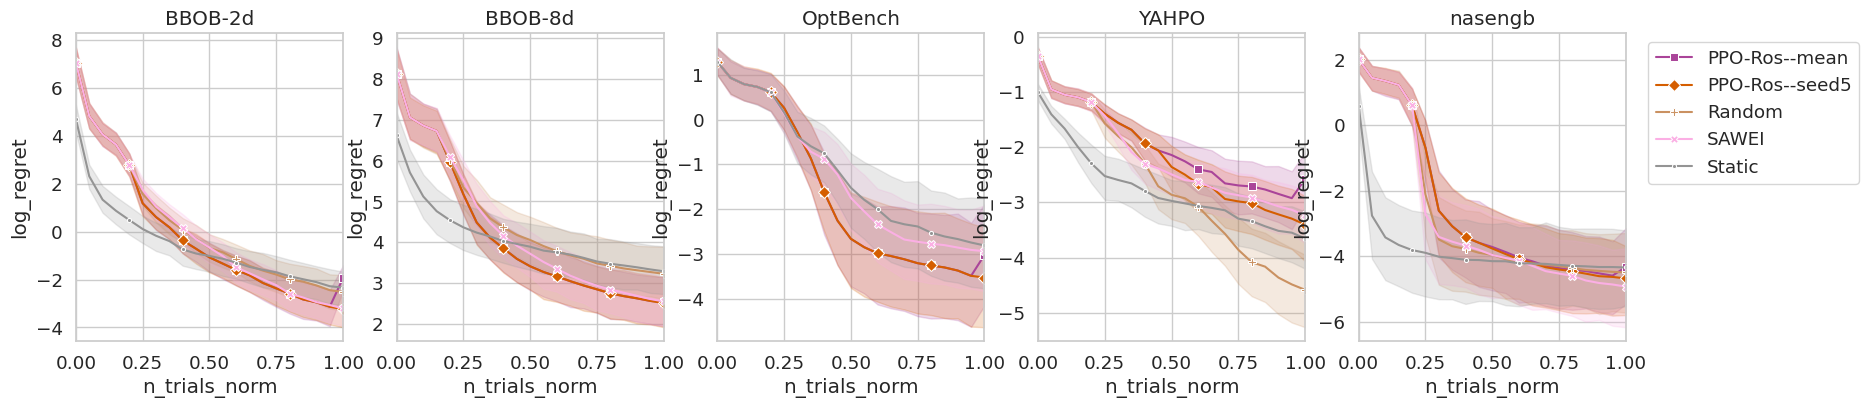

In [63]:
setup_seaborn()

logs_to_plot = logs[~logs["optimizer_id"].str.contains("bbob")].copy()

logs_to_plot = logs_to_plot[
    logs_to_plot["optimizer_id"].isin(opt_ids)
]

logs_to_plot = get_interpolated_performance_df(
    logs=logs_to_plot,
    interpolation_columns=["log_regret"],
    group_keys=["benchmark_id", "optimizer_id", "task_id", "seed"]
)
n_benchmarks = logs_to_plot["benchmark_id"].nunique()
fig = plt.figure(figsize=(4*n_benchmarks, 4))
axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)


for i, (benchmark_id, group) in enumerate(logs_to_plot.groupby("benchmark_id")):
    # if not benchmark_id.startswith("Opt"):
    #     continue
    ax = axes[i]
    ax = sns.lineplot(data=group, x="n_trials_norm", y=key_performance, hue="optimizer_id", palette=palette, ax=ax,
        style="optimizer_id", dashes=False, markers=marker_palette, markevery=4,
    )
    ax.set_title(benchmark_id)
    ax.legend().remove()
    ax.set_xlim(0, 1)
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Log Regret over Time Single per Benchmark

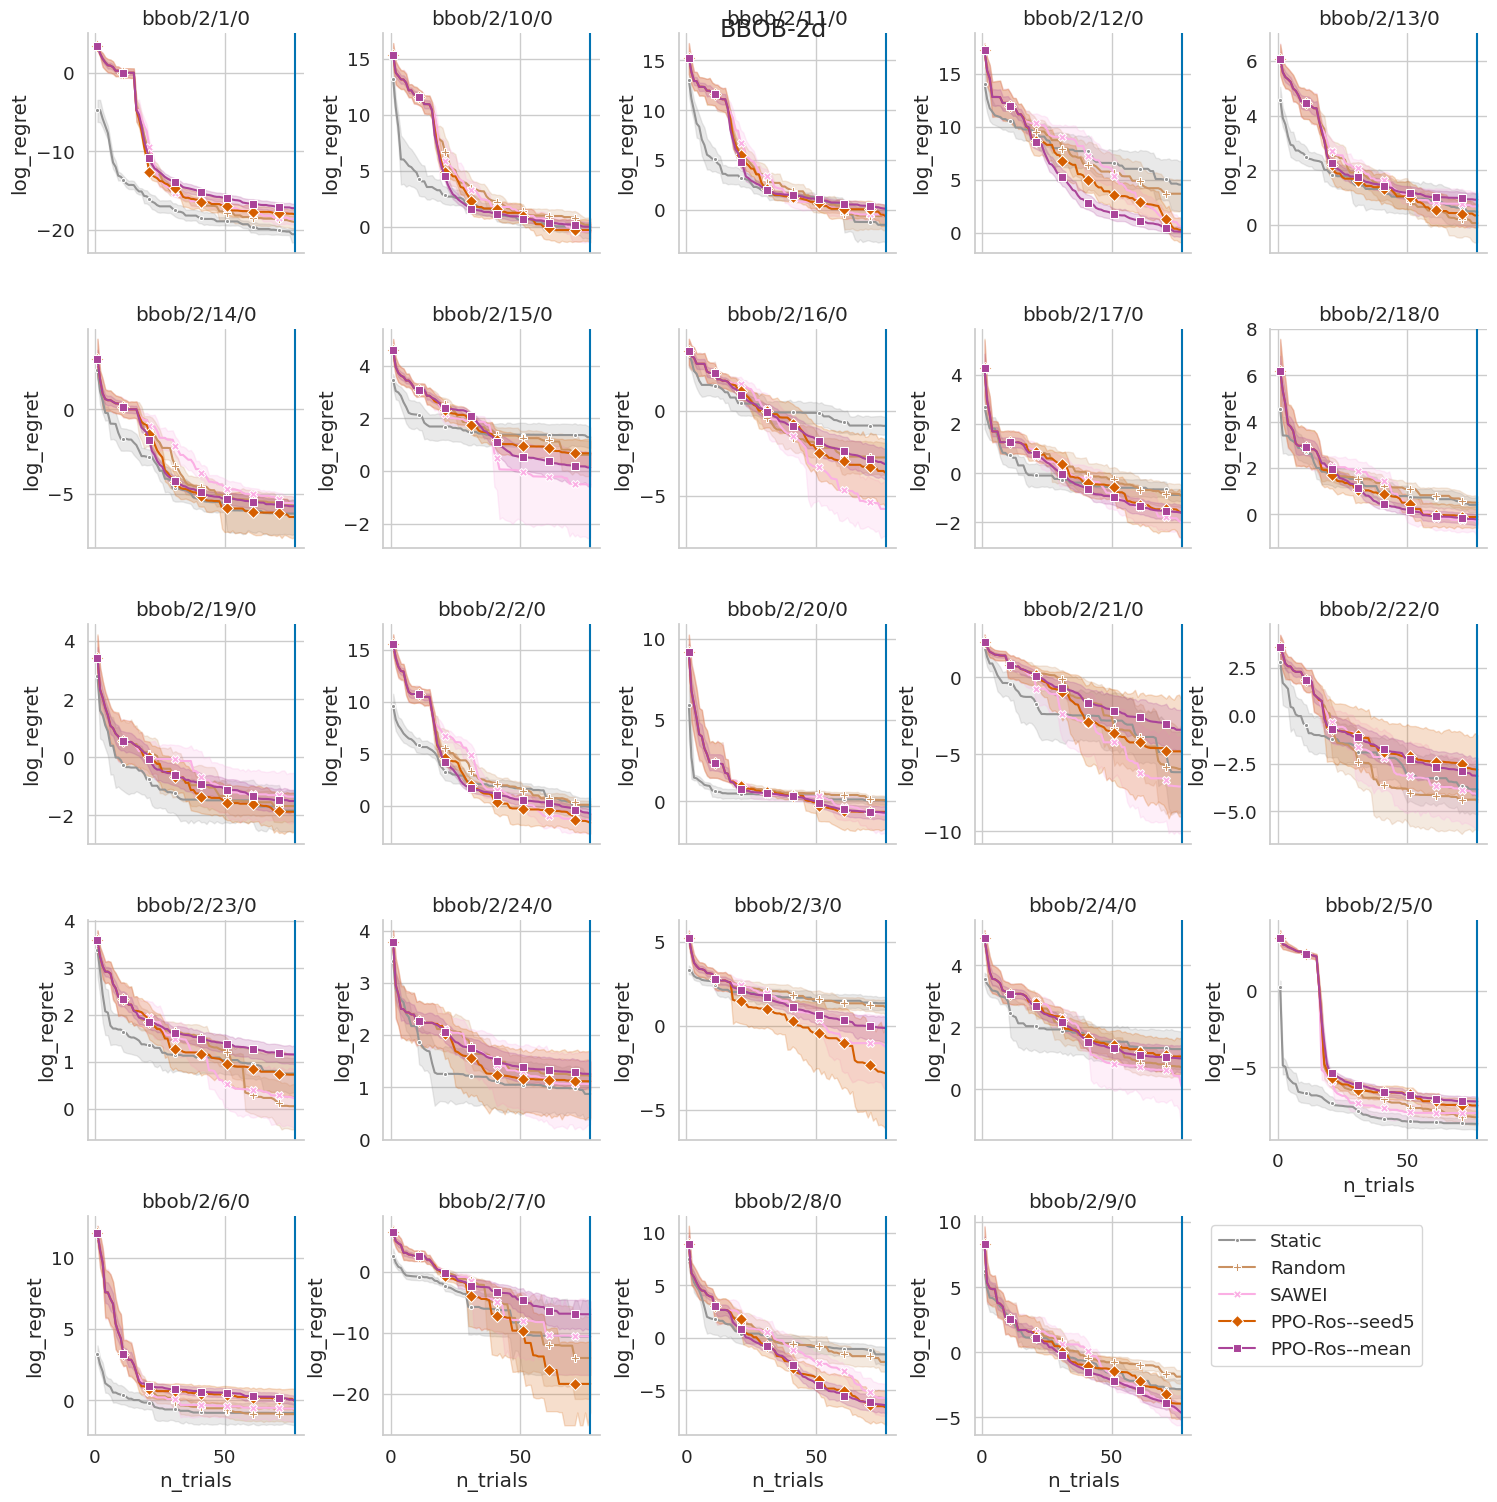

In [67]:

setup_seaborn()

logs_to_plot = logs[~logs["optimizer_id"].str.contains("bbob")].copy()
logs_to_plot = logs_to_plot[logs_to_plot["optimizer_id"].isin(opt_ids)]
for benchmark_id, group in logs_to_plot.groupby("benchmark_id"):
    if not benchmark_id.startswith("BBOB-2d"):
        continue

    grid = sns.FacetGrid(data=group, col="task_id", col_wrap=5, height=3, sharex=True, sharey=False)

    for i, (task_id, gdf) in enumerate(group.groupby("task_id")):
        ax = grid.axes.flat[i]
        ax = sns.lineplot(data=gdf, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette,
            style="optimizer_id", dashes=False, markers=marker_palette, markevery=10,
            ax=ax
        )
        ax.set_title(task_id)
        ax.legend().remove()
        ax.axvline(77)
    ax.legend(bbox_to_anchor=(1.05, 1))
    # grid.add_legend()
    grid.figure.suptitle(benchmark_id)
    # grid.tight_layout()
    plt.show()



# Rosenbrock 2d and 8d Barplot

optimizer_id
MetaBO-Ros       3.787321
Static          -1.575548
Random          -2.294580
SAWEI           -5.737017
PPO-Ros--mean   -6.438782
Name: log_regret, dtype: float64
-0.7017654364465598
optimizer_id
Random           6.446858
Static           6.095745
SAWEI            4.334570
PPO-Ros--mean    4.003324
Name: log_regret, dtype: float64
-0.33124622648803737


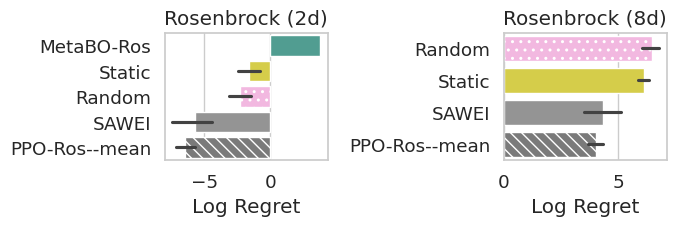

In [ ]:
setup_seaborn(font_scale=1.2)

skip_plot = df_final["optimizer_id"].nunique() > 20

df_final_to_plot = df_final[~df_final["optimizer_id"].str.contains("bbob")].copy()
df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.contains("seed")]
df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.contains("vbs")]
df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.contains("MetaBO-BBOB")]
df_final_to_plot = df_final_to_plot[
    df_final_to_plot["optimizer_id"].isin(opt_ids)
]
# df_final_to_plot = df_final


tasks = ["bbob/2/8/0", "bbob/8/8/0"]
df_final_to_plot = df_final_to_plot[df_final_to_plot["task_id"].isin(tasks)]
titles = {
    "bbob/2/8/0": "Rosenbrock (2d)",
    "bbob/8/8/0": "Rosenbrock (8d)",
}
for k, v in titles.items():
    df_final_to_plot.loc[df_final_to_plot["task_id"] == k, "task_id"] = v

fig = plt.figure(figsize=(7,2.5))
axes = fig.subplots(nrows=1, ncols=2, sharey=False, sharex=False)
for i, (task_id, gdf) in enumerate(df_final_to_plot.groupby("task_id")):
    gdf = sort_df_by_mean(gdf, key_performance="log_regret")

    ax = axes[i]
    # build optimizer -> hatch map
    hatch_map = {
        opt: hatch_for_optimizer(opt)
        for opt in gdf["optimizer_id"].unique()
    }

    sns.barplot(
        data=gdf,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )
    ax.set_xlabel("Log Regret")
    ax.set_ylabel(None)
    for patch, opt in zip(ax.patches, gdf["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))

    ax.set_title(task_id)


    df_mean = gdf.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    print(df_mean)
    print(df_mean.loc["PPO-Ros--mean"] - df_mean.loc["SAWEI"])

fig.tight_layout()
savefig(fig, "figures/results_icml/final_Rosenbrock")
plt.show()


# BBOB 2d and 8d

optimizer_id
MetaBO-Ros        2.443620
PPO-Ros--seed4   -1.930469
PPO-Ros--seed3   -2.028040
PPO-Ros--seed2   -2.310498
Static           -2.336011
PPO-Ros--mean    -2.432851
Random           -2.516334
PPO-Ros--seed1   -2.653921
SAWEI            -3.207305
PPO-Ros--seed5   -3.241328
Name: log_regret, dtype: float64
0.7744541209064701
optimizer_id
Static            3.288678
Random            3.226650
PPO-Ros--seed1    2.580998
SAWEI             2.550279
PPO-Ros--seed3    2.542414
PPO-Ros--seed4    2.533391
PPO-Ros--mean     2.518499
PPO-Ros--seed5    2.508917
PPO-Ros--seed2    2.426776
Name: log_regret, dtype: float64
-0.031780055297522036


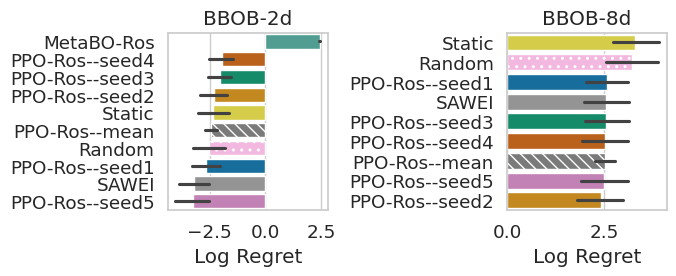

In [ ]:
setup_seaborn(font_scale=1.2)

skip_plot = df_final["optimizer_id"].nunique() > 20

df_final_to_plot = df_final[~df_final["optimizer_id"].str.contains("bbob")].copy()
# df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.contains("seed")]
df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.contains("vbs")]
df_final_to_plot = df_final_to_plot[
    df_final_to_plot["optimizer_id"].isin(opt_ids)
]
# df_final_to_plot = df_final


df_final_to_plot = df_final_to_plot[df_final_to_plot["benchmark_id"].str.startswith("BBOB")]
df_final_to_plot = df_final_to_plot[~df_final_to_plot["optimizer_id"].str.startswith("MetaBO-BBOB")]

fig = plt.figure(figsize=(7, 3))
axes = fig.subplots(nrows=1, ncols=df_final_to_plot["benchmark_id"].nunique(), sharey=False, sharex=False)
for i, (benchmark_id, gdf) in enumerate(df_final_to_plot.groupby("benchmark_id")):
    gdf = sort_df_by_mean(gdf, key_performance="log_regret")

    ax = axes[i]
    # build optimizer -> hatch map
    hatch_map = {
        opt: hatch_for_optimizer(opt)
        for opt in gdf["optimizer_id"].unique()
    }

    sns.barplot(
        data=gdf,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )
    ax.set_xlabel("Log Regret")
    ax.set_ylabel(None)
    for patch, opt in zip(ax.patches, gdf["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))

    ax.set_title(benchmark_id)


    df_mean = gdf.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    print(df_mean)
    print(df_mean.loc["PPO-Ros--mean"] - df_mean.loc["SAWEI"])

fig.tight_layout()
savefig(fig, "figures/results_icml/final_BBOB")
plt.show()


# OptBench, nasengb, YAHPO

optimizer_id
Static           -2.804651
PPO-Ros--seed1   -2.924423
SAWEI            -2.932277
PPO-Ros--seed3   -2.963749
PPO-Ros--seed4   -3.015597
PPO-Ros--seed2   -3.089098
PPO-Ros--mean    -3.102593
PPO-Ros--seed5   -3.520096
PPO-Ros--vbs     -3.702239
Name: log_regret, dtype: float64
-0.17031613019049718
optimizer_id
PPO-Ros--seed3   -4.258270
PPO-Ros--seed4   -4.327509
Static           -4.340700
Random           -4.493331
PPO-Ros--seed2   -4.497082
PPO-Ros--mean    -4.519913
PPO-Ros--seed5   -4.676515
PPO-Ros--seed1   -4.840189
SAWEI            -4.925604
PPO-Ros--vbs     -5.004818
Name: log_regret, dtype: float64
0.405691037390425
optimizer_id
PPO-Ros--seed4   -2.573304
PPO-Ros--seed2   -2.653504
PPO-Ros--seed3   -2.723307
PPO-Ros--mean    -2.907164
PPO-Ros--seed1   -3.181342
SAWEI            -3.236510
PPO-Ros--seed5   -3.404366
Static           -3.655135
PPO-Ros--vbs     -4.511069
Random           -4.585189
Name: log_regret, dtype: float64
0.3293452276780582


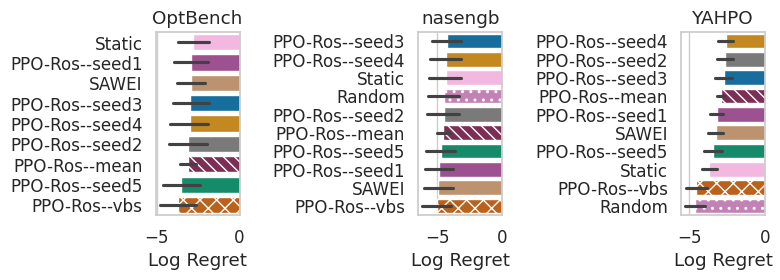

In [58]:
def hatch_for_optimizer(opt):
    if opt.endswith("vbs"):
        return "xx"
    if opt.endswith("mean"):
        return "\\\\\\"
    if opt.endswith("--seed") or "--seed" in opt:
        return ""
    if opt in {"DefaultPolicy", "SAWEI-P", "Random"}:
        return ".."
    return ""


setup_seaborn(font_scale=1.1)

skip_plot = df_final["optimizer_id"].nunique() > 20

df_final_to_plot = df_final[~df_final["optimizer_id"].str.contains("bbob")].copy()
df_final_to_plot = df_final_to_plot[
    df_final_to_plot["optimizer_id"].isin(opt_ids)
]
df_final_to_plot = df_final_to_plot[~df_final_to_plot["benchmark_id"].str.startswith("BBOB")]

benchmarks = ["OptBench", "nasengb", "YAHPO"]

fig = plt.figure(figsize=(8, 3))
axes = fig.subplots(nrows=1, ncols=df_final_to_plot["benchmark_id"].nunique(), sharey=False, sharex=False)
for i, benchmark_id in enumerate(benchmarks):
    gdf = df_final_to_plot[df_final_to_plot["benchmark_id"] == benchmark_id]
    # if benchmark_id != "YAHPO":
    #     gdf = gdf[~gdf["optimizer_id"].str.contains("vbs")]

    gdf = sort_df_by_mean(gdf, key_performance="log_regret")

    ax = axes[i]
    # build optimizer -> hatch map
    hatch_map = {
        opt: hatch_for_optimizer(opt)
        for opt in gdf["optimizer_id"].unique()
    }

    sns.barplot(
        data=gdf,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )
    ax.set_xlabel("Log Regret")
    ax.set_ylabel(None)
    for patch, opt in zip(ax.patches, gdf["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))

    ax.set_title(benchmark_id)


    df_mean = gdf.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    print(df_mean)
    print(df_mean.loc["PPO-Ros--mean"] - df_mean.loc["SAWEI"])

fig.tight_layout()
savefig(fig, "figures/results_icml/final_otherbenchmarks")
plt.show()


# YAHPO single task box

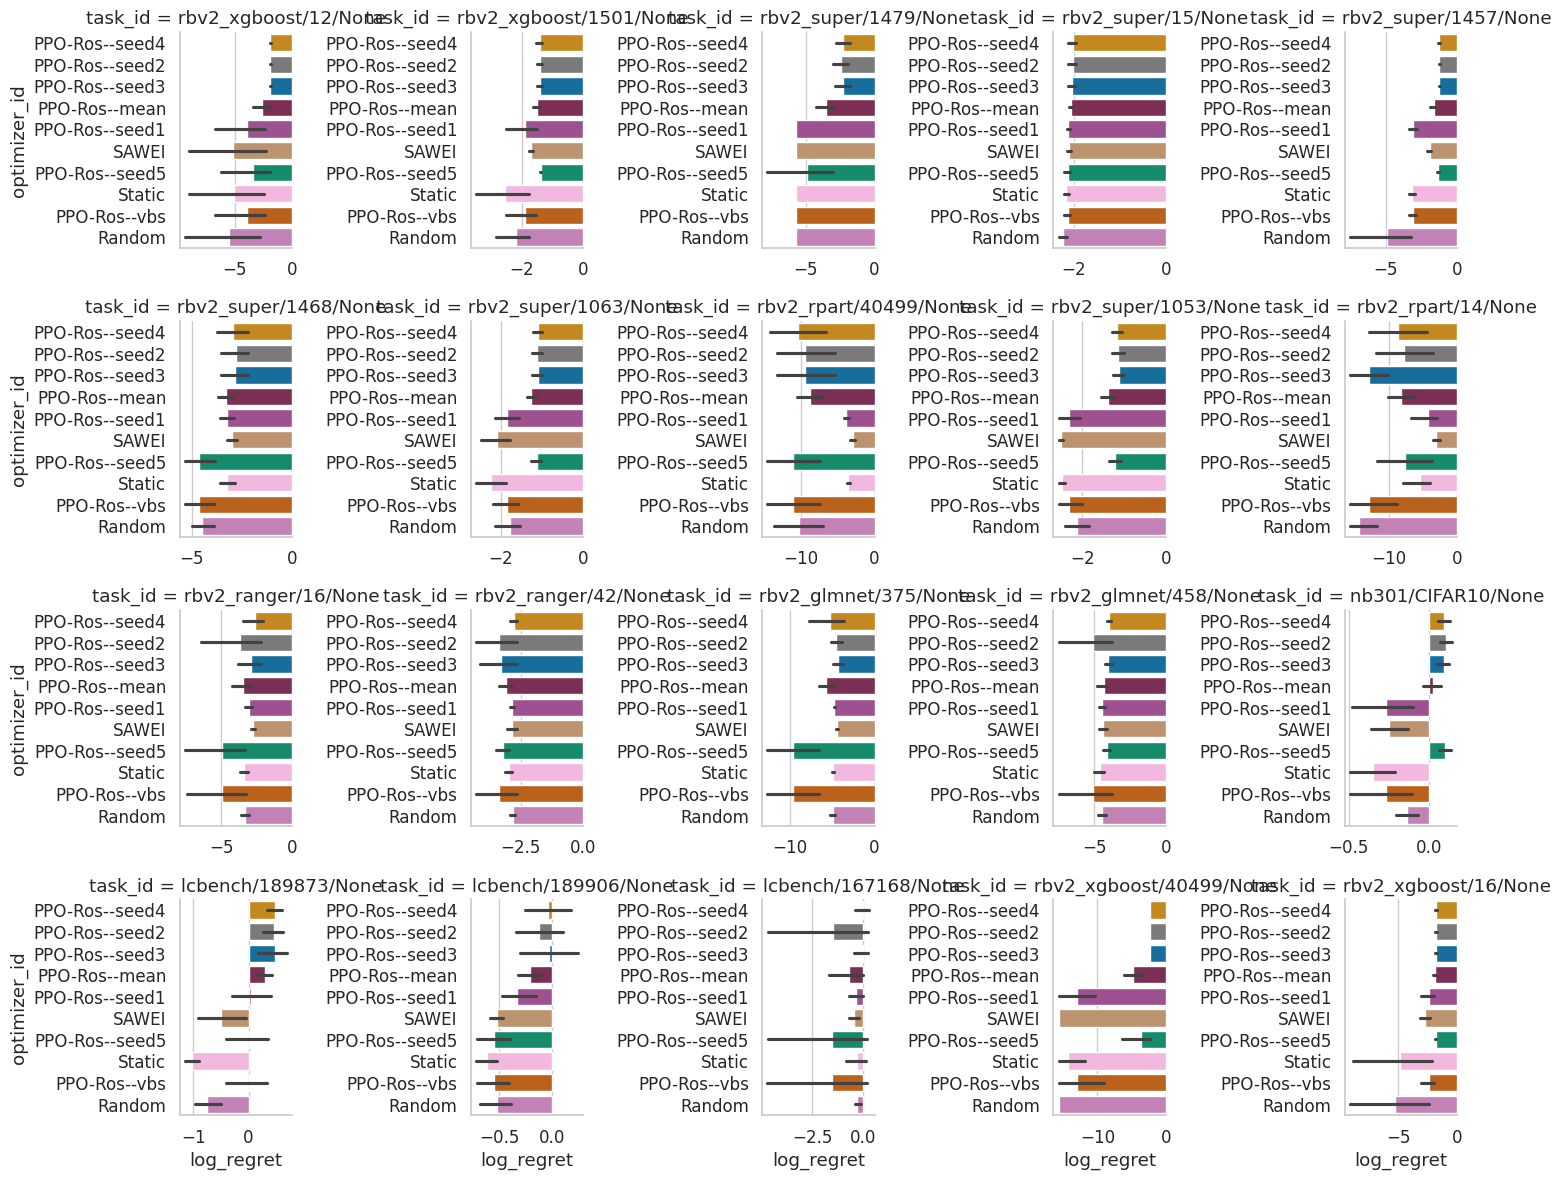

In [ ]:
setup_seaborn(font_scale=1.1)

skip_plot = df_final["optimizer_id"].nunique() > 20

df_final_to_plot = df_final[~df_final["optimizer_id"].str.contains("bbob")].copy()
df_final_to_plot = df_final_to_plot[
    df_final_to_plot["optimizer_id"].isin(opt_ids)
]
df_final_to_plot = df_final_to_plot[df_final_to_plot["benchmark_id"] == "YAHPO"]


df_final_to_plot = sort_df_by_mean(df_final_to_plot, key_performance="log_regret")

grid = sns.FacetGrid(data=df_final_to_plot, col="task_id", hue="optimizer_id", palette=palette,
                     col_wrap=5, sharey=False, sharex=False)
grid.map_dataframe(sns.barplot, x="log_regret", y="optimizer_id")

fig.tight_layout()
savefig(fig, "figures/results_icml/final_yahpo_single")
plt.show()


# MetaBO

optimizer_id
MetaBO-11     7.134700
MetaBO-12     6.665561
MetaBO-10     6.491579
MetaBO-02     5.706375
MetaBO-06     4.176196
MetaBO-07     2.834563
MetaBO-08     2.443620
MetaBO-18     2.302833
MetaBO-all    2.283107
MetaBO-20     1.994518
MetaBO-05     1.632936
MetaBO-17     1.505191
MetaBO-13     1.503099
MetaBO-22     1.298887
MetaBO-15     1.241647
MetaBO-03     1.089277
MetaBO-04     1.066418
MetaBO-01     1.026931
MetaBO-24     1.026033
MetaBO-23     0.776347
MetaBO-14     0.645540
MetaBO-16     0.564808
MetaBO-21     0.514935
MetaBO-09    -0.316757
MetaBO-19    -1.631941
Name: log_regret, dtype: float64
optimizer_id
MetaBO-12    7.628943
MetaBO-11    6.679705
MetaBO-10    6.210266
MetaBO-02    5.810761
MetaBO-06    5.189000
MetaBO-20    3.123430
MetaBO-13    2.946003
MetaBO-08    2.896229
MetaBO-03    2.759284
MetaBO-04    2.370419
MetaBO-05    2.160451
MetaBO-15    2.102517
MetaBO-07    2.061387
MetaBO-24    1.987251
MetaBO-09    1.978118
MetaBO-16    1.888778
MetaBO-22    1

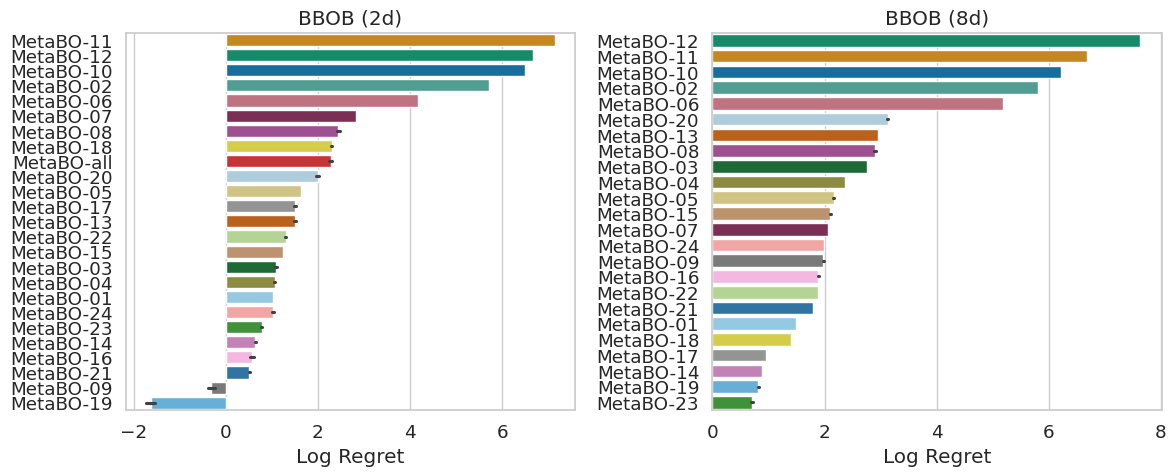

In [89]:
df_metabo = pd.read_csv(metabo_fn)
df_metabo["fid"] = df_metabo["task_id"].map(lambda x: int(x.split("/")[2]))
df_metabo["dim"] = df_metabo["task_id"].map(lambda x: int(x.split("/")[1]))
df_metabo["task_id"] = df_metabo["fid"].map(str) + "-" + df_metabo["dim"].map(str) + "d"
df_metabo["optimizer_id"] = df_metabo["optimizer_id"].map(lambda x: "MetaBO-all" if "BBOB-2D" in x else f"MetaBO-{int(x.split('-')[2]):02d}")


fig = plt.figure(figsize=(12, 5))
axes = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False)


palette = get_color_palette(df_metabo)

df_metabo_2d = df_metabo[df_metabo["dim"] == 2]
df_metabo_2d = sort_df_by_mean(df_metabo_2d, key_performance="log_regret")
df_mean = df_metabo_2d.groupby("optimizer_id")["log_regret"].apply(np.nanmean).sort_values(ascending=False)
print(df_mean)
ax = axes[0]
ax = sns.barplot(
    data=df_metabo_2d, x="log_regret", y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
ax.set_title("BBOB (2d)")
ax.set_xlabel("Log Regret")
ax.set_ylabel(None)


df_metabo_8d = df_metabo[df_metabo["dim"] == 8]
df_metabo_8d = sort_df_by_mean(df_metabo_8d, key_performance="log_regret")
df_mean = df_metabo_8d.groupby("optimizer_id")["log_regret"].apply(np.nanmean).sort_values(ascending=False)
print(df_mean)
ax = axes[1]
ax = sns.barplot(
    data=df_metabo_8d, x="log_regret", y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
ax.set_title("BBOB (8d)")
ax.set_xlabel("Log Regret")
ax.set_ylabel(None)

fig.tight_layout()
savefig(fig, "figures/results_icml/final_metabo")
plt.show()


# Table

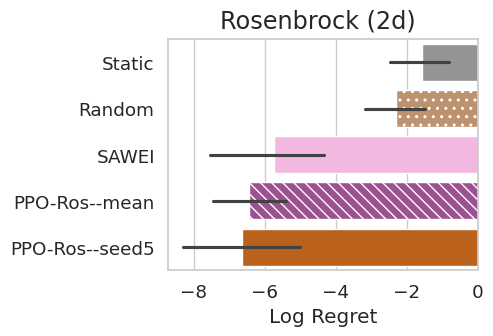

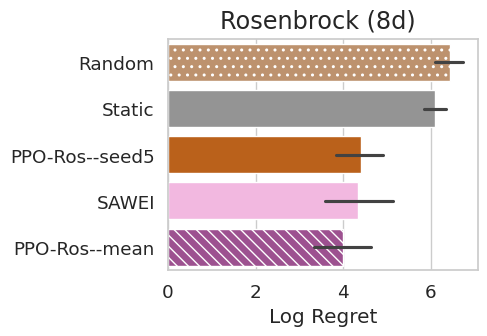

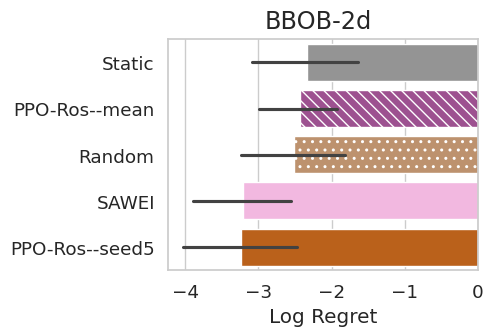

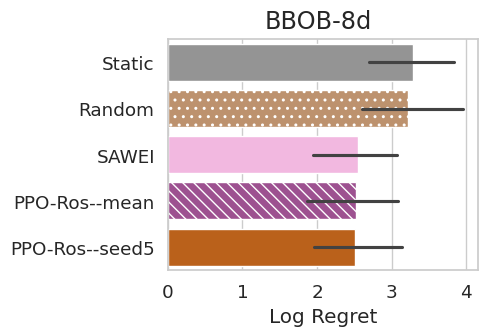

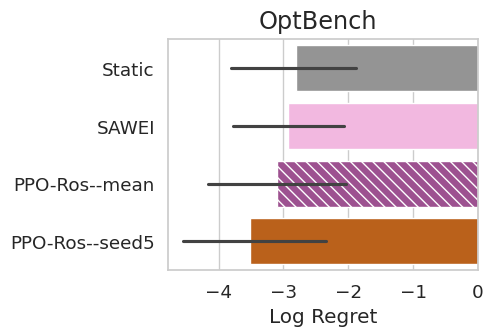

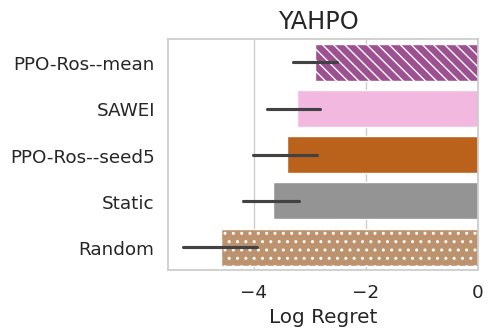

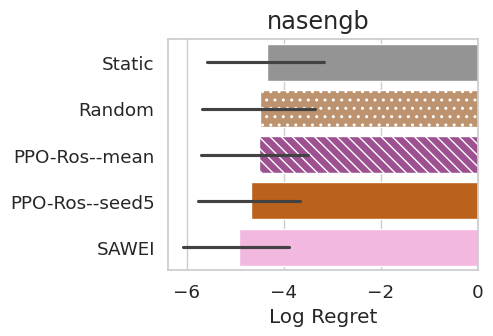

In [ ]:
def plot(df, palette, title):
    fig = plt.figure(figsize=(4, 3))
    ax = fig.add_subplot(111)

    # build optimizer -> hatch map
    optimizer_order = df["optimizer_id"].unique()
    hatch_map = {
        opt: hatch_for_optimizer(opt)
        for opt in df["optimizer_id"].unique()
    }

    # --- barplot ---
    sns.barplot(
        data=df,
        x="log_regret",
        y="optimizer_id",
        hue="optimizer_id",
        palette=palette,
        ax=ax,
        dodge=False
    )
    ax.set_xlabel("Log Regret")
    ax.set_ylabel(None)

    # apply hatches to barplot patches
    for patch, opt in zip(ax.patches, df["optimizer_id"].unique()):
        patch.set_hatch(hatch_map.get(opt, ""))

    fig.suptitle(title)
    savefig(fig, f"figures/results_icml/final_{title.replace('/','_').replace('(', '').replace(')', '').replace(' ', '')}")
    plt.show()

    # # ######################## Ranks
    # rank_df = df.assign(
    #     rank=df.groupby(["task_id", "seed"])["log_regret"]
    #         .rank(method="average", ascending=True)
    # )
    # rank_df = sort_df_by_mean(rank_df, key_performance="rank")

    # # --- plot ---
    # plt.figure(figsize=(3, 2.5))
    # ax = sns.barplot(
    #     data=rank_df,
    #     x="rank",
    #     y="optimizer_id",
    #     hue="optimizer_id",
    #     palette=palette
    # )

    # # apply hatches
    # for patch, opt in zip(ax.patches, df["optimizer_id"].unique()):
    #     patch.set_hatch(hatch_map.get(opt, ""))
    #     patch.set_edgecolor("white")
    #     patch.set_linewidth(1.5)

    # ax.set_xlabel("Mean Rank (lower is better)")
    # ax.set_ylabel("Optimizer")
    # ax.set_title("Optimizer Ranking by Mean Rank")

    # plt.tight_layout()
    # plt.show()

setup_seaborn(font_scale=1.2)

skip_plot = df_final["optimizer_id"].nunique() > 20

df_final_to_plot = df_final[~df_final["optimizer_id"].str.contains("bbob")].copy()
opt_ids = ["Static", "SAWEI", "Random", "PPO-Ros--seed5", "PPO-Ros--mean"]
df_final_to_plot = df_final_to_plot[
    df_final_to_plot["optimizer_id"].isin(opt_ids)
]
# df_final_to_plot = df_final


tasks = ["bbob/2/8/0", "bbob/8/8/0"]
titles = {
    "bbob/2/8/0": "Rosenbrock (2d)",
    "bbob/8/8/0": "Rosenbrock (8d)",
}
for task_id in tasks:
    df_task = df_final_to_plot[df_final_to_plot["task_id"] == task_id]
    df_task = sort_df_by_mean(df_task, key_performance="log_regret")

    df_task_mean = df_task.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    df_task_mean.to_csv(f"finalmean_{task_id.replace('/','_')}.csv")

    if not skip_plot:
        plot(df_task, palette, titles[task_id])

for benchmark_id, gdf in df_final_to_plot.groupby("benchmark_id"):
    n_tasks = gdf["task_id"].nunique()

    valid_opts = (
        gdf.groupby("optimizer_id")["task_id"]
        .nunique()
        .loc[lambda s: s == n_tasks]
        .index
    )

    gdf = gdf[gdf["optimizer_id"].isin(valid_opts)]

    gdf = sort_df_by_mean(gdf, key_performance="log_regret")

    gdf_mean = gdf.groupby("optimizer_id")[key_performance].apply(np.nanmean).sort_values(ascending=False)
    gdf_mean.to_csv(f"finalmean_{benchmark_id.replace('/','_')}.csv")

    if not skip_plot:
        plot(gdf, palette, benchmark_id)



# 2d fid8: Final Log Regret Boxplot & Log Regret over Time

/tmp/ipykernel_925308/1871963563.py:110: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


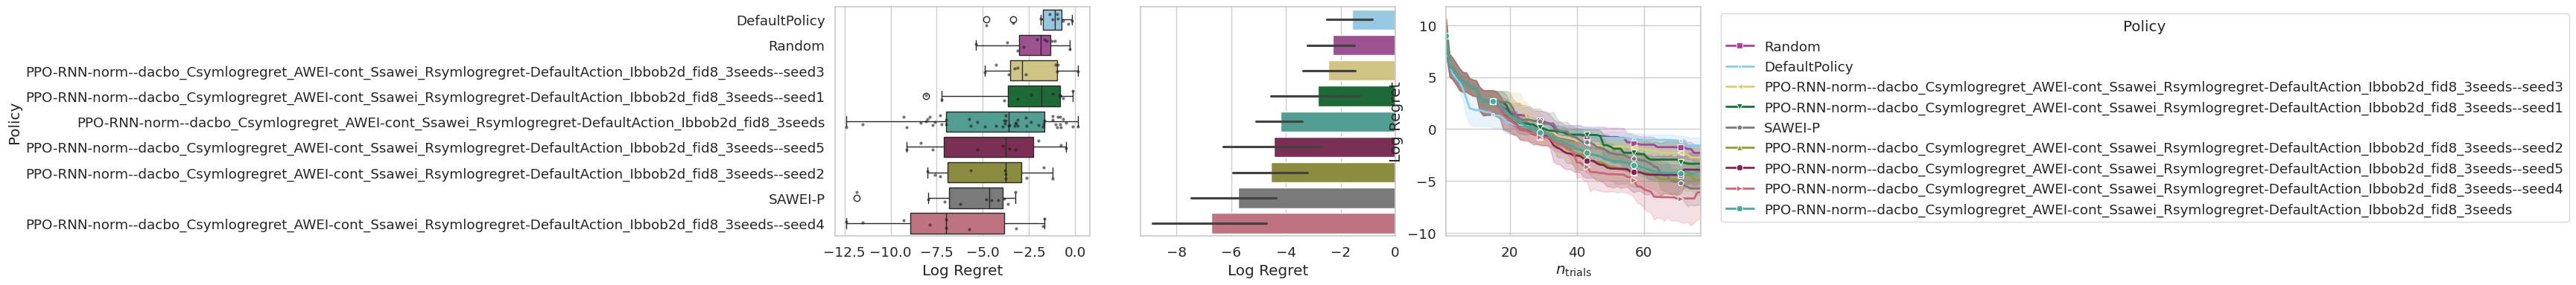

/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/pandas/core/groupby/ops.py:928: RuntimeWarning: Mean of empty slice
  res = f(group)


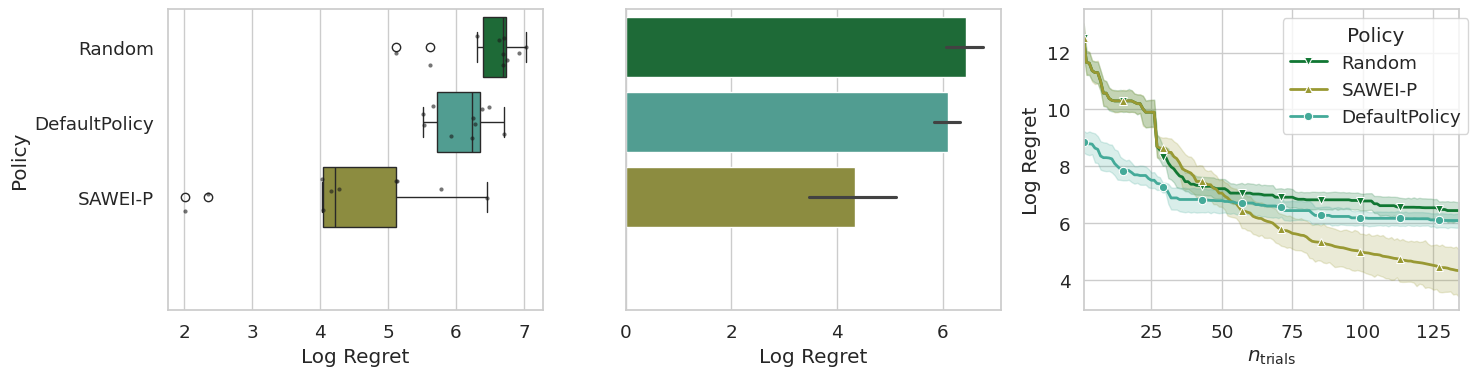

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs.loc[logs["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

# print(logs["optimizer_id"].unique())

# logs = logs[
#     # (logs["task_id"] == "bbob/2/8/0") \
#     (~logs["optimizer_id"].str.contains("bbob2d_3")) \
#     # & (~logs["optimizer_id"].str.contains("eplen")) \
#     & (~logs["optimizer_id"].str.contains("episode")) \
#     # & (~logs["optimizer_id"].str.contains("symlog")) \
#     & (~logs["optimizer_id"].str.contains("SMAC-")) \
#     & (~logs["optimizer_id"].str.contains("SMAC3-")) \
#     # & (~logs["optimizer_id"].str.contains("PPO-")) \
# ]
logs = logs[
    (logs["optimizer_id"].isin(["DefaultPolicy", "NoOpPolicy", "Random", "SAWEI-P"])) \
    | ((logs["optimizer_id"].str.contains("symlog")) \
    & (logs["optimizer_id"].str.contains("cont")) \
    & (logs["optimizer_id"].str.contains("fid8")) \
    & (logs["optimizer_id"].str.contains("DefaultAction")) \
    & (logs["optimizer_id"].str.contains("norm")) \
    )
]
# logs_ppo = logs[logs["optimizer_id"].str.startswith("PPO")].copy()
# logs_ppo["train_seed"] = logs_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
# logs_ppo["optimizer_id"] = logs["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))
# logs = pd.concat([logs, logs_ppo]).reset_index(drop=True)
# palette = get_color_palette(logs)
# markers = get_marker_palette(logs)

def reduce_ppo(logs: pd.DataFrame) -> pd.DataFrame:
    logs_ppo = logs[logs["optimizer_id"].str.startswith("PPO")].copy()
    logs_ppo["train_seed"] = logs_ppo["optimizer_id"].map(lambda x: int(x.split("--")[-1].replace("seed", "")))
    logs_ppo["optimizer_id"] = logs["optimizer_id"].map(lambda x: "--".join(x.split("--")[:-1]))
    logs = pd.concat([logs, logs_ppo]).reset_index(drop=True)
    return logs

for task_id in ["bbob/2/8/0", "bbob/8/8/0"]:
    logs_to_plot = logs[logs["task_id"] == task_id]
    logs_to_plot = sort_df_by_mean(logs_to_plot, key_performance=key_performance)
    df_final = filter_only_final_performance(logs_to_plot)

    logs_to_plot = reduce_ppo(logs_to_plot)
    df_final = reduce_ppo(df_final)

    palette = get_color_palette(logs_to_plot)
    markers = get_marker_palette(logs_to_plot)


    df_final = sort_df_by_mean(df_final, key_performance=key_performance)
    hue_order = logs_to_plot["optimizer_id"].unique()

    fig = plt.figure(figsize=(15,4))
    axes = fig.subplots(ncols=3, sharex=False, sharey=False)
    ax = axes[2]
    ax = sns.lineplot(data=logs_to_plot, x="n_trials", y=key_performance, hue="optimizer_id", palette=palette,
                style="optimizer_id", dashes=False, markers=markers, markevery=14, linewidth=2,
                # estimator=None, units="seed", linewidth=0.5,
                ax=ax, hue_order=hue_order,
                )
    ax.legend(title="Policy", bbox_to_anchor=(1.05, 1))
    ax.set_xlim(logs_to_plot["n_trials"].min(), logs_to_plot["n_trials"].max())
    ax.set_xlabel("$n_\\mathrm{trials}$")
    ax.set_ylabel("Log Regret")

    ax = axes[0]
    ax = sns.boxplot(data=df_final, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
    ax.set_ylabel("Policy")
    ax.set_xlabel("Log Regret")

    sns.stripplot(
        data=df_final,
        y="optimizer_id",
        color="k",
        # hue="optimizer_id",
        # palette=palette,
        x="log_regret",
        order=hue_order,
        jitter=0.25,
        size=3,
        alpha=0.6,
        ax=ax
    )

    ax = axes[1]
    ax = sns.barplot(data=df_final, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=palette, ax=ax)
    ax.set_ylabel(None)
    ax.set_yticklabels([])
    ax.set_xlabel("Log Regret")

    fig.tight_layout()
    fn = "figures/results_icml/fid8_8d" if not "2" in task_id else "figures/results_icml/fid8_2d"
    savefig(fig=fig, filename=fn)
    plt.show()


# Fid8: 2d and 8d boxplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

setup_seaborn(font_scale=1.2)

key_performance = "log_regret"
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].isin(["bbob/2/8/0","bbob/8/8/0"])) \
    & (~logs["optimizer_id"].str.contains("bbob2d_3")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
]
logs.loc[logs["task_id"] == "bbob/2/8/0", "task_id"] = "Rosenbrock-2d"
logs.loc[logs["task_id"] == "bbob/8/8/0", "task_id"] = "Rosenbrock-8d"
palette = get_color_palette(logs)
logs = sort_df_by_mean(logs, key_performance=key_performance)
logs = logs.sort_values(
    by="task_id",
    key=lambda x: x.str.extract('(\d+)')[0].astype(int)
)
df_final = filter_only_final_performance(logs)

key_performance = "Log Regret (Normalized)"
df_final[key_performance] = df_final.groupby("task_id")["log_regret"].transform(normalize)
df_final = df_final.sort_values(
    by="task_id",
    key=lambda x: x.str.extract('(\d+)')[0].astype(int)
)
df_final = sort_df_by_mean(df_final, key_performance=key_performance)
hue_order = logs["optimizer_id"].unique()
markers = get_marker_palette(logs)

fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax = sns.boxplot(
    data=df_final, y=key_performance, hue="optimizer_id", x="task_id", palette=palette, ax=ax)
ax.legend(title="Policy", bbox_to_anchor=(1.05,1))
# ax.tick_params(axis="x", rotation=90)
ax.set_xlabel("Task ID")
fig.tight_layout()
savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_8d")
plt.show()


# Fid8 Generalization on BBOB 2d

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D
import numpy as np

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

key_performance = "log_regret"
palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("bbob2d_3")) \
    & (~logs["optimizer_id"].str.contains("episode")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
]
print(logs["task_id"].unique())
palette = get_color_palette(logs)
logs = sort_df_by_mean(logs, key_performance=key_performance)
df_final = filter_only_final_performance(logs)

# -----------------------------
# Sort optimizers by performance
# -----------------------------
optimizer_order = (
    df_final
    .groupby("optimizer_id")["regret"]
    .mean()
    .sort_values()
    .index
)

# -----------------------------
# Automatic floor for -inf
# -----------------------------
finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5

# -----------------------------
# Prepare plotting DataFrame
# -----------------------------
df_plot = df_final.copy()
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret_plot"] = df_plot["log_regret"].replace(-np.inf, floor)

df_plot["optimizer_id"] = pd.Categorical(
    df_plot["optimizer_id"],
    categories=optimizer_order,
    ordered=True
)

# -----------------------------
# Main plot: boxplot + jitter + annotations
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))


sns.stripplot(
    data=df_plot,
    y="optimizer_id",
    hue="optimizer_id",
    palette=palette,
    x="log_regret_plot",
    order=optimizer_order,
    jitter=0.25,
    size=3,
    alpha=0.6,
    ax=ax
)

sns.boxplot(
    data=df_plot,
    y="optimizer_id",
    x="log_regret_plot",
    hue="optimizer_id",
    palette=palette,
    order=optimizer_order,
    width=0.6,
    fliersize=0,
    ax=ax,
    fill=False,
    zorder=9999,
    linewidth=3,
    medianprops={"color": "black", "linewidth": 1.5},
)



# Annotate solved counts
solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()

for y, opt in enumerate(optimizer_order):
    ax.text(
        floor + 0.02,
        y,
        f"{solved_counts[opt]} solved",
        va="center",
        ha="left",
        fontsize=8
    )

ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
ax.set_xlabel("Final Log Regret")
ax.set_ylabel("Policy")
plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_bbob2d")
plt.show()

# key_performance_norm = "Log Regret (Normalized)"
# df_final[key_performance_norm] = df_final.groupby("task_id")["log_regret"].transform(normalize)

# df_final = sort_df_by_mean(df_final, key_performance=key_performance_norm)
# hue_order = logs["optimizer_id"].unique()
# markers = get_marker_palette(logs)

# fig = plt.figure(figsize=(10,3.5))
# ax = fig.add_subplot(111)
# ax = sns.boxplot(
#     data=df_final, x=key_performance_norm, hue="optimizer_id", y="optimizer_id", palette=palette, ax=ax)
# # ax.tick_params(axis="x", rotation=90)
# ax.set_xlabel("Log Regret (Normalized)")
# ax.set_ylabel("Policy")
# fig.tight_layout()
# savefig(fig=fig, filename="figures/results_icml/fid8_2d_vs_8d")
# plt.show()


# BBOB2d on BBOB2d

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import adaptaf.utils as au
importlib.reload(au)
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import (
    filter_only_final_performance,
    get_color_palette,
    get_marker_palette,
    savefig,
    setup_seaborn,
)
from carps.analysis.gather_data import normalize
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

key_performance = "log_regret"

palette = get_color_palette(logs)
logs = logs[
    (logs["task_id"].str.startswith("bbob/2")) \
    & (~logs["optimizer_id"].str.contains("fid8")) \
    & (~logs["optimizer_id"].str.contains("-SMAC")) \
    & (~logs["optimizer_id"].str.contains("episode")) \
]
palette = get_color_palette(logs)
df_final = filter_only_final_performance(logs)

# -----------------------------
# Sort optimizers by performance
# -----------------------------
optimizer_order = (
    df_final
    .groupby("optimizer_id")["regret"]
    .mean()
    .sort_values()
    .index
)

# -----------------------------
# Automatic floor for -inf
# -----------------------------
finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5

# -----------------------------
# Prepare plotting DataFrame
# -----------------------------
df_plot = df_final.copy()
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret_plot"] = df_plot["log_regret"].replace(-np.inf, floor)

df_plot["optimizer_id"] = pd.Categorical(
    df_plot["optimizer_id"],
    categories=optimizer_order,
    ordered=True
)

# -----------------------------
# Main plot: boxplot + jitter + annotations
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 4))


sns.stripplot(
    data=df_plot,
    y="optimizer_id",
    hue="optimizer_id",
    palette=palette,
    x="log_regret_plot",
    order=optimizer_order,
    jitter=0.25,
    size=3,
    alpha=0.6,
    ax=ax
)

sns.boxplot(
    data=df_plot,
    y="optimizer_id",
    x="log_regret_plot",
    hue="optimizer_id",
    palette=palette,
    order=optimizer_order,
    width=0.6,
    fliersize=0,
    ax=ax,
    fill=False,
    zorder=9999,
    linewidth=3,
    medianprops={"color": "black", "linewidth": 1.5},
)



# Annotate solved counts
solved_counts = df_plot.groupby("optimizer_id")["solved"].sum()

for y, opt in enumerate(optimizer_order):
    ax.text(
        floor + 0.02,
        y,
        f"{solved_counts[opt]} solved",
        va="center",
        ha="left",
        fontsize=8
    )

ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
ax.set_xlabel("Final Log Regret")
ax.set_ylabel("Policy")
plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/bbob2d_on_bbob2d")
plt.show()




In [ ]:
# -----------------------------
# Heatmap with solved counts per cell
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data: number of runs solved per task & optimizer
# 1 if log_regret = -inf, 0 otherwise
df_solved = df_final.copy()
df_solved["solved"] = (df_solved["log_regret"] == -np.inf).astype(int)

# Pivot table: tasks x optimizers, sum over multiple runs
task_counts = df_solved.pivot_table(
    index="task_id",
    columns="optimizer_id",
    values="solved",
    aggfunc="sum",
    fill_value=0
).reindex(columns=optimizer_order)

# Binary mask for heatmap coloring: 1 = solved at least once
task_binary = (task_counts > 0).astype(int)

fig, ax = plt.subplots(figsize=(8, 8))

# Base heatmap: solved vs not solved
sns.heatmap(
    task_counts.T,
    cbar=False,
    linewidths=0.3,
    linecolor="gray",
    cmap="Greens",
    ax=ax,
    annot=task_counts.T,      # overlay the **number of solved runs**
    fmt="d",
    annot_kws={"fontsize": 8, "fontweight": "bold"}
)

ax.set_ylabel("Policy")
ax.set_xlabel("Task ID")
ax.set_title("Tasks on which the solution was found (numbers = solved runs)")

# plt.tight_layout()
savefig(fig=fig, filename="figures/results_icml/sol_found_bbob2d")
plt.show()


# Final Log Regret Agg Benchmark

In [ ]:
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import filter_only_final_performance, savefig
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)


logs = logs[logs["benchmark_id"] != "BBOB-2d"]
# logs = logs[
#         # (~logs["optimizer_id"].str.contains("fid8")) \
#         # & (~logs["optimizer_id"].str.contains("-SAWEI")) \
#         # & (~logs["optimizer_id"].str.contains("-SMAC")) \
#         # & (~logs["optimizer_id"].str.contains("sym")) 
# ]
logs.loc[logs["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
opts_to_plot = [
    "PPO-AlphaNet--dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret-SMAC3-BlackBoxFacade_Ibbob2d_3seeds--seed3",
    "SAWEI-P",
    "DefaultPolicy",
    "Random"
]
logs = logs[logs["optimizer_id"].isin(opts_to_plot)]
df_final = filter_only_final_performance(logs)

finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret"] = df_plot["log_regret"].replace(-np.inf, floor)

methods_overview_plot = df_final["optimizer_id"].unique()

n_benchmarks = df_final["benchmark_id"].nunique()
benchmark_ids = df_final["benchmark_id"].unique()
color_palette = get_color_palette(df_final)
# color_palette["SAWEI-P"] = "red"
# color_palette["DefaultPolicy"] = "green"
# color_palette["Random"] = "blue"

fig = plt.figure(figsize=(4 * n_benchmarks, 3 * n_benchmarks))
axes = fig.subplots(ncols=1, nrows=n_benchmarks, sharex=False, sharey=False)
# axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)

for i, benchmark_id in enumerate(benchmark_ids):
    ax = axes[i]
    # df_bench = df_final[
    #     (df_final["benchmark_id"] == benchmark_id) & \
    #     (
    #         df_final["optimizer_id"].str.contains("fid8") | \
    #      df_final["optimizer_id"].str.contains("Default") | \
    #      df_final["optimizer_id"].str.contains("Random") | \
    #      df_final["optimizer_id"].str.contains("SAWEI-P") \
    #     #  | df_final["optimizer_id"].str.contains("SMAC") \
    #      | df_final["optimizer_id"].str.contains("symlog") \
    #      )
    # ]
    df_bench = df_final[
        (df_final["benchmark_id"] == benchmark_id) \
    ]
    df_bench = sort_df_by_mean(df_bench, key_performance=key_performance)
    ax = sns.barplot(
        data=df_bench, x=key_performance, y="optimizer_id", hue="optimizer_id", palette=color_palette, ax=ax)

    yticklabels = ax.get_yticklabels()
    ax.set_title(benchmark_id)
    ax.set_xlabel("Log Regret")
    ylabel = "Optimizer" if i == 0 else None
    ax.set_ylabel(ylabel)
fig.tight_layout()
savefig(fig, "figures/results_icml/perf_per_benchmark")
plt.show()


df_reduced = df_final.groupby(["optimizer_id", "benchmark_id"])[key_performance].mean().reset_index()
df_reduced = sort_df_by_mean(data=df_reduced, key_performance=key_performance)
df_reduced_reduced = df_reduced.groupby(["optimizer_id"])[key_performance].mean().reset_index()
df_reduced_reduced = sort_df_by_mean(data=df_reduced_reduced, key_performance=key_performance)
fig = plt.figure(figsize=(6,15))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette)
ax = sns.stripplot(data=df_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax, palette=color_palette, linewidth=1, jitter=False)
ax = sns.stripplot(
    data=df_reduced_reduced, x=key_performance, y="optimizer_id", hue="optimizer_id", ax=ax,
    palette=color_palette, linewidth=1, size=10, marker="d", jitter=False)
yticklabels = ax.get_yticklabels()

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Mean per Benchmark",
           markerfacecolor="grey", markersize=5),  # small circle
    Line2D([0], [0], marker="d", color="w", label="Mean",
           markerfacecolor="grey", markersize=10)   # larger diamond
]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), ncols=2, fontsize=10, loc="upper center")
ax.set_xlabel("Log Regret")
ax.set_ylabel("Optimizer")
savefig(fig, "figures/results_icml/perf_on_all")
plt.show()



In [ ]:
from dacboenv.experiment.analysis.utils import sort_df_by_mean
from carps.analysis.utils import filter_only_final_performance, savefig
from matplotlib.lines import Line2D

%matplotlib inline

setup_seaborn(font_scale=1.2)

# df_final = pd.read_parquet(df_final_fn)
logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)

finite_vals = df_final.loc[
    np.isfinite(df_final["log_regret"]),
    "log_regret"
]
floor = finite_vals.min() - 0.5
df_plot["solved"] = df_plot["log_regret"].eq(-np.inf)
df_plot["log_regret"] = df_plot["log_regret"].replace(-np.inf, floor)

methods_overview_plot = df_final["optimizer_id"].unique()

n_benchmarks = df_final["benchmark_id"].nunique()
benchmark_ids = df_final["benchmark_id"].unique()
color_palette = get_color_palette(df_final)

fig = plt.figure(figsize=(5 * n_benchmarks, 4))
axes = fig.subplots(nrows=1, ncols=n_benchmarks, sharex=False, sharey=False)

for i, benchmark_id in enumerate(benchmark_ids):
    ax = axes[i]
    df_bench = df_final[
        (df_final["benchmark_id"] == benchmark_id) & \
        (df_final["optimizer_id"].str.contains("bbob_2d") | \
         df_final["optimizer_id"].str.contains("Default") | \
         df_final["optimizer_id"].str.contains("SAWEI")
         )
    ]
    df_bench = sort_df_by_mean(df_bench, key_performance=key_performance)
    ax = sns.boxplot(
        data=df_bench, x=key_performance, y="optimizer_id", hue="optimizer_id",
        palette=color_palette, ax=ax, showfliers=False)

    yticklabels = ax.get_yticklabels()
    ax.set_title(benchmark_id)
    ax.set_xlabel("Log Regret")
    ylabel = "Optimizer" if i == 0 else None
    ax.set_ylabel(ylabel)
    # ax.axvline(floor, linestyle="--", linewidth=2, color="gray")
fig.tight_layout()
savefig(fig, "figures/results_icml/perf_per_benchmark_boxplot")
plt.show()


# SAWEI-P on Mixed / YAHPO

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from carps.analysis.utils import savefig, setup_seaborn

%matplotlib inline

setup_seaborn()

# logs = pd.read_parquet(Path(result_dir) / logsprocessed_fn)
# logs_cfg = pd.read_parquet(Path(result_dir) / logsprocessed_cfg_fn)
df_final = pd.read_parquet(Path(result_dir) / df_final_processed_fn)
df_final.loc[df_final["optimizer_id"] == "NoOpPolicy", "optimizer_id"] = "DefaultPolicy"
df_final = df_final[df_final["optimizer_id"].isin(["DefaultPolicy", "SAWEI-P"])]

for benchmark_id, gdf in df_final.groupby("benchmark_id"):
    print(benchmark_id)
    sns.boxplot(data=gdf, x="optimizer_id", y="log_regret", hue="optimizer_id")
    plt.show()
    sns.barplot(data=gdf, x="optimizer_id", y="log_regret", hue="optimizer_id")
    plt.show()
    grid = sns.FacetGrid(data=gdf, col="task_id", hue="optimizer_id", col_wrap=5, sharex=True, sharey=False)
    grid.map_dataframe(sns.boxplot, x="optimizer_id", y="log_regret")
    grid.figure.suptitle(benchmark_id)
    grid.add_legend()
    grid.tight_layout()
    plt.show()